In [1]:
import torch
from tqdm.auto import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from pathlib import Path
from datasets import load_dataset
from torchvision import transforms
from typing import Optional, Tuple, List
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import json
import torchvision.transforms.functional as F

c:\Users\Ivan\miniconda3\envs\course_project_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class Vocab:
    def __init__(self, vocab_path=None, token_list=None):
        self.pad = "<PAD>"
        self.bos = "<SOS>"
        self.eos = "<EOS>"
        self.unk = "<UNK>"
        
        if vocab_path:
            self._load_from_file(vocab_path)
        elif token_list:
            self._build_from_tokens(token_list)
        else:
            raise ValueError("Either vocab_path or token_list must be provided")
        
        self.length = len(self.tokens)
    
    def _load_from_file(self, vocab_path):
        with open(vocab_path, 'r', encoding='utf-8') as f:
            loaded_vocab = json.load(f)
        
        if self.pad in loaded_vocab and self.bos in loaded_vocab and \
           self.eos in loaded_vocab and self.unk in loaded_vocab:
            self.stoi = loaded_vocab
            self.itos = {i: t for t, i in self.stoi.items()}
            self.tokens = [self.itos[i] for i in range(len(self.itos))]
        else:
            token_list = list(loaded_vocab.keys())
            self._build_from_tokens(token_list)
    
    def _build_from_tokens(self, token_list):
        special_tokens = [self.pad, self.bos, self.eos, self.unk]
        filtered_tokens = [t for t in token_list if t not in special_tokens]
        
        self.tokens = special_tokens + sorted(set(filtered_tokens))
        self.stoi = {t: i for i, t in enumerate(self.tokens)}
        self.itos = {i: t for t, i in self.stoi.items()}
    
    def __len__(self):
        return self.length
    
    def encode(self, token_seq):
        if not isinstance(token_seq, list):
            raise ValueError(f"Expected list of tokens, got {type(token_seq)}")
        
        if not all(isinstance(t, str) for t in token_seq):
            raise ValueError("All tokens must be strings")
        
        return [self.stoi[self.bos]] + \
               [self.stoi.get(t, self.stoi[self.unk]) for t in token_seq] + \
               [self.stoi[self.eos]]
    
    def decode(self, ids):
        eos_id = self.stoi[self.eos]
        pad_id = self.stoi[self.pad]
        bos_id = self.stoi[self.bos]
        
        toks = []
        for i in ids:
            if i == eos_id:
                break
            if i not in (pad_id, bos_id):
                toks.append(self.itos[i])
        
        return " ".join(toks)
    
    def save(self, vocab_path):
        with open(vocab_path, 'w', encoding='utf-8') as f:
            json.dump(self.stoi, f, ensure_ascii=False, indent=2)


In [4]:
class ResizeWithPad:
    def __init__(self, target_size=224, fill=255):
        self.target_size = target_size
        self.fill = fill
    
    def __call__(self, image):
        w, h = image.size
        
        ratio = self.target_size / max(w, h)
        new_w = int(w * ratio)
        new_h = int(h * ratio)
        
        image = F.resize(image, (new_h, new_w), antialias=True)
        
        delta_w = self.target_size - new_w
        delta_h = self.target_size - new_h
        
        padding = (
            delta_w // 2,
            delta_h // 2,
            delta_w - (delta_w // 2),
            delta_h - (delta_h // 2)
        )
        
        image = F.pad(image, padding, fill=self.fill, padding_mode='constant')
        
        return image

In [5]:
from build_vocabulary import LaTeXTokenizer


class LaTeXDataset(Dataset):
    def __init__(
        self,
        images_dir: str,
        vocab,
        cache_dir: str = r'D:\datasets',
        split: str = 'train',
        transform: Optional[transforms.Compose] = None,
        max_latex_len: int = 512
    ):
        self.images_dir = Path(images_dir)
        self.vocab = vocab
        self.tokenizer = LaTeXTokenizer()
        self.transform = transform or self._default_transform()
        
        print(f"Loading dataset from HuggingFace...")
        ds = load_dataset(
            "hoang-quoc-trung/fusion-image-to-latex-datasets",
            cache_dir=cache_dir,
            split=split
        )
        
        print(f"Filtering by LaTeX length <= {max_latex_len}...")
        ds = ds.filter(lambda x: len(x['latex']) <= max_latex_len)
        
        self.filenames = ds['image_filename']
        self.latex_formulas = ds['latex']
        
        print(f"Dataset ready: {len(self.filenames)} samples")

    def _default_transform(self):
        return transforms.Compose([
            ResizeWithPad(target_size=224, fill=255),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        image_filename = self.filenames[idx]
        latex = self.latex_formulas[idx]
        img_path = self.images_dir / image_filename
        
        try:
            image = Image.open(img_path).convert('RGB')
            image = self.transform(image)
        except Exception as e:
            image = torch.zeros((3, 224, 224))
        
        tokens = self.tokenizer.tokenize(latex)
        encoded_tokens = self.vocab.encode(tokens)
        token_tensor = torch.LongTensor(encoded_tokens)
        
        return image, token_tensor

In [6]:
def collate_fn(batch):
    images, token_tensors = zip(*batch)
    
    images = torch.stack(images, dim=0)
    
    max_len = max(len(t) for t in token_tensors)
    pad_id = 0
    
    padded_tokens = []
    for tokens in token_tensors:
        padding = torch.full((max_len - len(tokens),), pad_id, dtype=torch.long)
        padded = torch.cat([tokens, padding])
        padded_tokens.append(padded)
    
    token_batch = torch.stack(padded_tokens, dim=0)
    
    return images, token_batch

In [7]:
def get_dataloaders(
    images_dir: str = r"D:\datasets\extraction\root\images",
    vocab=None,
    cache_dir: str = r'D:\datasets',
    batch_size: int = 32,
    num_workers: int = 0,
    max_latex_len: int = 512
):
    
    train_dataset = LaTeXDataset(
        images_dir=images_dir,
        vocab=vocab,
        cache_dir=cache_dir,
        split='train[:5%]',
        max_latex_len=max_latex_len
    )
    
    val_dataset = LaTeXDataset(
        images_dir=images_dir,
        vocab=vocab,
        cache_dir=cache_dir,
        split='validation',
        max_latex_len=max_latex_len
    )
    
    test_dataset = LaTeXDataset(
        images_dir=images_dir,
        vocab=vocab,
        cache_dir=cache_dir,
        split='test',
        max_latex_len=max_latex_len
    )
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        collate_fn=collate_fn,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=collate_fn,
        pin_memory=True
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=collate_fn,
        pin_memory=True
    )
    
    return train_loader, val_loader, test_loader

vocab = Vocab(vocab_path='tokens.json')

train_loader, val_loader, test_loader = get_dataloaders(
    images_dir=r"D:\datasets\extraction\root\images",
    vocab=vocab,
    cache_dir=r'D:\datasets',
    batch_size=128,
    num_workers=0,
    max_latex_len=64
)
    
print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")
    
images, tokens = next(iter(train_loader))
print(f"\nTrain batch - Images: {images.shape}, Tokens: {tokens.shape}")
    
images, tokens = next(iter(val_loader))
print(f"Val batch - Images: {images.shape}, Tokens: {tokens.shape}")
    
images, tokens = next(iter(test_loader))
print(f"Test batch - Images: {images.shape}, Tokens: {tokens.shape}")


Loading dataset from HuggingFace...
Filtering by LaTeX length <= 64...
Dataset ready: 53819 samples
Loading dataset from HuggingFace...
Filtering by LaTeX length <= 64...
Dataset ready: 1078 samples
Loading dataset from HuggingFace...
Filtering by LaTeX length <= 64...
Dataset ready: 4009 samples
Train batches: 421
Validation batches: 9
Test batches: 32

Train batch - Images: torch.Size([128, 3, 224, 224]), Tokens: torch.Size([128, 35])
Val batch - Images: torch.Size([128, 3, 224, 224]), Tokens: torch.Size([128, 29])
Test batch - Images: torch.Size([128, 3, 224, 224]), Tokens: torch.Size([128, 31])


In [8]:
import torchvision.models as models

class ResNetEncoder(nn.Module):
    def __init__(self, hidden_dim=256, freeze_layers=True):
        super().__init__()
        
        resnet = models.resnet50(pretrained=True)
        
        if freeze_layers:
            for param in resnet.layer1.parameters():
                param.requires_grad = False
            for param in resnet.layer2.parameters():
                param.requires_grad = False
            for param in resnet.layer3.parameters():
                param.requires_grad = False
            for param in resnet.layer4.parameters():
                param.requires_grad = True
        
        self.features = nn.Sequential(*list(resnet.children())[:-2])
        self.adaptive_pool = nn.AdaptiveAvgPool2d((7, 7))
        self.projection = nn.Linear(2048, hidden_dim)
    
    def forward(self, x):
        x = self.features(x)
        x = self.adaptive_pool(x)
        B, C, H, W = x.shape
        x = x.permute(0, 2, 3, 1).reshape(B, H*W, C)
        x = self.projection(x)
        return x


In [9]:
class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, hidden_dim=256, num_layers=4, nhead=8, dropout=0.1, max_len=512):
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, hidden_dim)
        self.pos_emb = nn.Embedding(max_len, hidden_dim)
        self.max_len = max_len

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=hidden_dim,
            nhead=nhead,
            dim_feedforward=hidden_dim * 4,
            dropout=dropout,
            batch_first=True,
        )
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(hidden_dim, vocab_size)
        
        # Создаем маску один раз и кэшируем
        self.register_buffer('causal_mask', torch.triu(torch.ones(max_len, max_len), diagonal=1).bool())

    def forward(self, tgt, memory):
        B, T = tgt.shape
        tok_emb = self.token_emb(tgt)  # [B,T,H]
        pos = self.pos_emb(torch.arange(T, device=tgt.device))  # [T,H]
        pos = pos.unsqueeze(0).expand(B, -1, -1)
        tgt_emb = tok_emb + pos

        # Используем маску
        tgt_mask = self.causal_mask[:T, :T]

        out = self.transformer_decoder(tgt_emb, memory, tgt_mask=tgt_mask)  # [B,T,H]
        return self.fc_out(out)

In [10]:
# Итоговая модель 
class FormulaRecognizer(nn.Module):
    def __init__(self, vocab_size, hidden_dim=256, max_len=512):
        super().__init__()
        self.encoder = ResNetEncoder(hidden_dim, freeze_layers=True)
        self.decoder = TransformerDecoder(vocab_size, hidden_dim, max_len=max_len)
        self.max_len = max_len
        self.vocab_size = vocab_size

    def forward(self, images, tokens):
        memory = self.encoder(images)  # [B,S,H]
        out = self.decoder(tokens[:, :-1], memory)  # предсказываем без последнего токена
        return out  # [B,T-1,V]

    def greedy_decode(self, image, vocab, device="cpu"):
        self.eval()
        with torch.no_grad():
            memory = self.encoder(image.unsqueeze(0).to(device))  # [1,S,H]

            # Используем правильные токены из словаря
            start_token = vocab.stoi[vocab.bos]
            end_token = vocab.stoi[vocab.eos]
            
            tokens = torch.tensor([[start_token]], device=device)
            for _ in range(self.max_len):
                out = self.decoder(tokens, memory)  # [1,T,V]
                next_token = out[:, -1, :].argmax(-1)  # [1]
                tokens = torch.cat([tokens, next_token.unsqueeze(0)], dim=1)
                if next_token.item() == end_token:
                    break

        return tokens.squeeze(0).tolist()

In [11]:
def save_checkpoint(model, optimizer, epoch, train_loss, val_loss):
    checkpoint = {
        'epoch': epoch+1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss
    }
    torch.save(checkpoint, os.path.join("checkpoints",f"checkpoint_epoch_{epoch+1}.pth"))
    print(f"Checkpoint saved: epoch {epoch+1}, train_loss={train_loss:.4f}, val_loss={val_loss:.4f}")

def save_best(model, optimizer, epoch, train_loss, val_loss):
    checkpoint = {
        'epoch': epoch+1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss
    }
    torch.save(checkpoint, os.path.join("checkpoints",f"checkpoint_best.pth"))
    print(f"Checkpoint saved: epoch {epoch+1}, train_loss={train_loss:.4f}, val_loss={val_loss:.4f}")

def load_checkpoint(model, optimizer, filepath='checkpoints/checkpoint_best.pth'):
    if os.path.exists(filepath):
        checkpoint = torch.load(filepath, weights_only=True)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        train_loss = checkpoint['train_loss']
        val_loss = checkpoint['val_loss']
        print(f"Checkpoint loaded: epoch {epoch}, train_loss={train_loss:.4f}, val_loss={val_loss:.4f}")
        return epoch, train_loss, val_loss
    else:
        print(f"No checkpoint found at {filepath}")
        return 0, float('inf'), float('inf')

In [12]:
from torch.cuda.amp import autocast, GradScaler
def train_model(model, train_loader, val_loader, test_loader, tokenizer, epochs=5, device="cuda"):
    criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.stoi[tokenizer.pad])  # паддинг
    optimizer = optim.AdamW(model.parameters(), lr=1e-3)
    scaler = GradScaler()

    model = model.to(device)
    best_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        train_correct = 0
        train_total = 0
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")
        
        for imgs, tokens in train_bar:
            imgs, tokens = imgs.to(device), tokens.to(device)
            
            optimizer.zero_grad()
            
            with autocast():
                outputs = model(imgs, tokens[:, :-1])
                
                min_len = min(outputs.size(1), tokens[:, 1:].size(1))
                outputs = outputs[:, :min_len, :]
                targets = tokens[:, 1:1+min_len]
                
                loss = criterion(
                    outputs.reshape(-1, outputs.size(-1)),
                    targets.reshape(-1)
                )
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            total_loss += loss.item()
            
            preds = outputs.argmax(-1)  # [B, T]
            pad_id = tokenizer.stoi[tokenizer.pad]
            
            for i in range(preds.size(0)):
                pred_tokens = preds[i].cpu().tolist()
                true_tokens = tokens[i, 1:1+min_len].cpu().tolist()
                
                for j in range(min(len(pred_tokens), len(true_tokens))):
                    if true_tokens[j] != pad_id:
                        if pred_tokens[j] == true_tokens[j]:
                            train_correct += 1
                        train_total += 1
            
            train_bar.set_postfix(loss=loss.item(), acc=f"{train_correct/train_total:.3f}")

        avg_train_loss = total_loss / len(train_loader)
        train_accuracy = train_correct / train_total if train_total > 0 else 0

        # ---------- VALID ----------
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        examples = []
        with torch.no_grad():
            val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]")
            for imgs, tokens in val_bar:
                imgs, tokens = imgs.to(device), tokens.to(device)
                outputs = model(imgs, tokens[:, :-1])

                min_len = min(outputs.size(1), tokens[:, 1:].size(1))
                outputs = outputs[:, :min_len, :]
                targets = tokens[:, 1:1+min_len]

                loss = criterion(
                    outputs.reshape(-1, outputs.size(-1)),
                    targets.reshape(-1)
                )
                val_loss += loss.item()

                # Подсчет accuracy для валидационной выборки (по токенам)
                preds = outputs.argmax(-1)  # [B, T]
                pad_id = tokenizer.stoi[tokenizer.pad]
                
                for i in range(preds.size(0)):
                    # Сравниваем токены по отдельности
                    pred_tokens = preds[i].cpu().tolist()
                    true_tokens = tokens[i, 1:1+min_len].cpu().tolist()
                    
                    # Считаем совпадения только для не-pad токенов
                    for j in range(min(len(pred_tokens), len(true_tokens))):
                        if true_tokens[j] != pad_id:  # Игнорируем pad токены в истинных значениях
                            if pred_tokens[j] == true_tokens[j]:
                                val_correct += 1
                            val_total += 1

                if len(examples) < 3:
                    pred_text = tokenizer.decode([t for t in preds[0].cpu().tolist() if t != pad_id])
                    true_text = tokenizer.decode([t for t in tokens[0, 1:1+min_len].cpu().tolist() if t != pad_id])
                    examples.append((pred_text, true_text))

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = val_correct / val_total if val_total > 0 else 0

        print(f"\nEpoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.3f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.3f}")
        for i, (pred, true) in enumerate(examples):
            print(f"  EX{i+1}: pred = {pred}")
            print(f"       true = {true}")

        save_checkpoint(model, optimizer, epoch, avg_train_loss, avg_val_loss)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            save_best(model, optimizer, epoch, avg_train_loss, avg_val_loss)
            print(f"Best model saved!")

        torch.cuda.empty_cache()
    
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0
    test_examples = []
    with torch.no_grad():
        test_bar = tqdm(test_loader, desc="Тестирование")
        for imgs, tokens in test_bar:
            imgs, tokens = imgs.to(device), tokens.to(device)
            outputs = model(imgs, tokens[:, :-1])

            min_len = min(outputs.size(1), tokens[:, 1:].size(1))
            outputs = outputs[:, :min_len, :]
            targets = tokens[:, 1:1+min_len]

            loss = criterion(
                outputs.reshape(-1, outputs.size(-1)),
                targets.reshape(-1)
            )
            test_loss += loss.item()

            # Подсчет accuracy для тестовой выборки (по токенам)
            preds = outputs.argmax(-1)  # [B, T]
            pad_id = tokenizer.stoi[tokenizer.pad]
            
            for i in range(preds.size(0)):
                # Сравниваем токены по отдельности
                pred_tokens = preds[i].cpu().tolist()
                true_tokens = tokens[i, 1:1+min_len].cpu().tolist()
                
                # Считаем совпадения только для не-pad токенов
                for j in range(min(len(pred_tokens), len(true_tokens))):
                    if true_tokens[j] != pad_id:  # Игнорируем pad токены в истинных значениях
                        if pred_tokens[j] == true_tokens[j]:
                            test_correct += 1
                        test_total += 1

            if len(test_examples) < 5:  # Показываем больше примеров для теста
                pred_text = tokenizer.decode([t for t in preds[0].cpu().tolist() if t != pad_id])
                true_text = tokenizer.decode([t for t in tokens[0, 1:1+min_len].cpu().tolist() if t != pad_id])
                test_examples.append((pred_text, true_text))

    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = test_correct / test_total if test_total > 0 else 0
    print(f"\nФинальная оценка на тестовой выборке:")
    print(f"Test Loss: {avg_test_loss:.4f} | Test Accuracy: {test_accuracy:.3f}")
    print(f"Test Examples:")
    for i, (pred, true) in enumerate(test_examples):
        print(f"  TEST{i+1}: pred = {pred}")
        print(f"           true = {true}")
    

    return avg_test_loss, test_accuracy



In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = FormulaRecognizer(vocab_size=len(vocab))

c:\Users\Ivan\miniconda3\envs\course_project_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Ivan\miniconda3\envs\course_project_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
test_loss, test_accuracy = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    tokenizer=vocab,
    epochs=20,
    device=device
)

C:\Users\Ivan\AppData\Local\Temp\ipykernel_9088\217622372.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/20 [Train]:   0%|          | 0/421 [00:00<?, ?it/s]C:\Users\Ivan\AppData\Local\Temp\ipykernel_9088\217622372.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/20 [Val]: 100%|██████████| 9/9 [00:09<00:00,  1.05s/it]



Epoch 1/20 | Train Loss: 2.2874 | Train Acc: 0.503 | Val Loss: 1.3889 | Val Acc: 0.655
  EX1: pred = a _ { 1 } + x _ { i } } } x x _ { i } i }
       true = x _ { i } - x _ { i + 1 } + x _ { i + 2 }
  EX2: pred = 1 _ { 1 } - 1 _ { 2 } - _ _ _
       true = k _ { 1 } = k _ { 2 }
  EX3: pred = a + + 1 1 + ) - ) ) = 1 + 0
       true = 2 0 + ( 9 6 \div 9 2 ) = 2 1 . 0 4
Checkpoint saved: epoch 1, train_loss=2.2874, val_loss=1.3889
Checkpoint saved: epoch 1, train_loss=2.2874, val_loss=1.3889
Best model saved!


Epoch 2/20 [Val]: 100%|██████████| 9/9 [00:04<00:00,  2.21it/s]



Epoch 2/20 | Train Loss: 1.1587 | Train Acc: 0.717 | Val Loss: 1.1936 | Val Acc: 0.706
  EX1: pred = f ( { i } + x _ { i + 1 } + x _ { i + 2 }
       true = x _ { i } - x _ { i + 1 } + x _ { i + 2 }
  EX2: pred = k _ { 1 } ^ k _ { 2 }
       true = k _ { 1 } = k _ { 2 }
  EX3: pred = y 8 + 1 1 7 ) 3 ) ) ^ 3 7
       true = 2 0 + ( 9 6 \div 9 2 ) = 2 1 . 0 4
Checkpoint saved: epoch 2, train_loss=1.1587, val_loss=1.1936
Checkpoint saved: epoch 2, train_loss=1.1587, val_loss=1.1936
Best model saved!


Epoch 3/20 [Val]: 100%|██████████| 9/9 [00:11<00:00,  1.27s/it]



Epoch 3/20 | Train Loss: 0.8275 | Train Acc: 0.790 | Val Loss: 0.5818 | Val Acc: 0.853
  EX1: pred = x _ { i } - x _ { i + 1 } + x _ { i + 2 }
       true = x _ { i } - x _ { i + 1 } + x _ { i + 2 }
  EX2: pred = k _ { 1 } = k
       true = k _ { 1 } = k _ { 2 }
  EX3: pred = 9 0 + ( 6 - - 5 5 ) = 1 4 4 4 4
       true = 2 0 + ( 9 6 \div 9 2 ) = 2 1 . 0 4
Checkpoint saved: epoch 3, train_loss=0.8275, val_loss=0.5818
Checkpoint saved: epoch 3, train_loss=0.8275, val_loss=0.5818
Best model saved!


Epoch 4/20 [Val]: 100%|██████████| 9/9 [00:07<00:00,  1.28it/s]



Epoch 4/20 | Train Loss: 0.7283 | Train Acc: 0.812 | Val Loss: 0.5081 | Val Acc: 0.867
  EX1: pred = x _ { 1 } - x _ { i + 1 } + x _ { i + 2 }
       true = x _ { i } - x _ { i + 1 } + x _ { i + 2 }
  EX2: pred = k = { 1 } = k _ { 2 }
       true = k _ { 1 } = k _ { 2 }
  EX3: pred = \sin n + ( 1 4 - 3 3 ) - 1 4 4 4 4
       true = 2 0 + ( 9 6 \div 9 2 ) = 2 1 . 0 4
Checkpoint saved: epoch 4, train_loss=0.7283, val_loss=0.5081
Checkpoint saved: epoch 4, train_loss=0.7283, val_loss=0.5081
Best model saved!


Epoch 5/20 [Val]: 100%|██████████| 9/9 [00:06<00:00,  1.35it/s]



Epoch 5/20 | Train Loss: 0.6358 | Train Acc: 0.834 | Val Loss: 0.5010 | Val Acc: 0.869
  EX1: pred = x _ { 1 } - x _ { i + 1 } + x _ { i + 2 }
       true = x _ { i } - x _ { i + 1 } + x _ { i + 2 }
  EX2: pred = k _ { 1 } = k _ { 2 }
       true = k _ { 1 } = k _ { 2 }
  EX3: pred = 8 0 + ( 1 8 \div 1 8 ) = 1 1 6 3 4
       true = 2 0 + ( 9 6 \div 9 2 ) = 2 1 . 0 4
Checkpoint saved: epoch 5, train_loss=0.6358, val_loss=0.5010
Checkpoint saved: epoch 5, train_loss=0.6358, val_loss=0.5010
Best model saved!


Epoch 6/20 [Val]: 100%|██████████| 9/9 [00:04<00:00,  2.15it/s]



Epoch 6/20 | Train Loss: 0.6705 | Train Acc: 0.826 | Val Loss: 0.7359 | Val Acc: 0.811
  EX1: pred = 7 ( { 1 + - x _ { i + 1 } + x _ { i + 2 }
       true = x _ { i } - x _ { i + 1 } + x _ { i + 2 }
  EX2: pred = k _ { 1 } = k _ { 2 }
       true = k _ { 1 } = k _ { 2 }
  EX3: pred = 2 + + ( 1 \div \div 6 6 ) = 2 1 . 1 7
       true = 2 0 + ( 9 6 \div 9 2 ) = 2 1 . 0 4
Checkpoint saved: epoch 6, train_loss=0.6705, val_loss=0.7359


Epoch 7/20 [Val]: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]



Epoch 7/20 | Train Loss: 0.6476 | Train Acc: 0.829 | Val Loss: 0.4495 | Val Acc: 0.883
  EX1: pred = Y _ { 1 + + x _ { i + 1 } + x _ { i + 2 }
       true = x _ { i } - x _ { i + 1 } + x _ { i + 2 }
  EX2: pred = k _ { 1 } = k _ { 2 }
       true = k _ { 1 } = k _ { 2 }
  EX3: pred = 3 8 + ( 1 8 - 1 6 ) - - 1
       true = 2 0 + ( 9 6 \div 9 2 ) = 2 1 . 0 4
Checkpoint saved: epoch 7, train_loss=0.6476, val_loss=0.4495
Checkpoint saved: epoch 7, train_loss=0.6476, val_loss=0.4495
Best model saved!


Epoch 8/20 [Val]: 100%|██████████| 9/9 [00:05<00:00,  1.79it/s]



Epoch 8/20 | Train Loss: 0.4918 | Train Acc: 0.867 | Val Loss: 1.6091 | Val Acc: 0.651
  EX1: pred = x _ { i + - x _ { i + 1 } , \sum _ { i + 1 }
       true = x _ { i } - x _ { i + 1 } + x _ { i + 2 }
  EX2: pred = k _ { 1 } = \operatorname _ { 1 } ( _ _ _ _
       true = k _ { 1 } = k _ { 2 }
  EX3: pred = 8 8 3 ( ( 6 + 9 ) ) \div 3 . . 3 3 9 3 3
       true = 2 0 + ( 9 6 \div 9 2 ) = 2 1 . 0 4
Checkpoint saved: epoch 8, train_loss=0.4918, val_loss=1.6091


Epoch 9/20 [Val]: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]



Epoch 9/20 | Train Loss: 0.4500 | Train Acc: 0.877 | Val Loss: 0.3248 | Val Acc: 0.920
  EX1: pred = x _ { i } - x _ { i + 1 } + x _ { i + 2 }
       true = x _ { i } - x _ { i + 1 } + x _ { i + 2 }
  EX2: pred = k _ { 1 } = k _ { 2 }
       true = k _ { 1 } = k _ { 2 }
  EX3: pred = 2 0 + ( 2 2 - 3 7 ) = 2 1 . 3 3
       true = 2 0 + ( 9 6 \div 9 2 ) = 2 1 . 0 4
Checkpoint saved: epoch 9, train_loss=0.4500, val_loss=0.3248
Checkpoint saved: epoch 9, train_loss=0.4500, val_loss=0.3248
Best model saved!


Epoch 10/20 [Val]: 100%|██████████| 9/9 [00:04<00:00,  2.10it/s]



Epoch 10/20 | Train Loss: 0.4002 | Train Acc: 0.889 | Val Loss: 0.4244 | Val Acc: 0.889
  EX1: pred = x _ { i } - x _ { i + 1 } + x _ { i + 2 }
       true = x _ { i } - x _ { i + 1 } + x _ { i + 2 }
  EX2: pred = k _ { 1 } , k _ { 2 }
       true = k _ { 1 } = k _ { 2 }
  EX3: pred = 9 6 + ( 1 9 - ( 9 ) = 2 1 . 1 2
       true = 2 0 + ( 9 6 \div 9 2 ) = 2 1 . 0 4
Checkpoint saved: epoch 10, train_loss=0.4002, val_loss=0.4244


Epoch 11/20 [Val]: 100%|██████████| 9/9 [00:06<00:00,  1.43it/s]



Epoch 11/20 | Train Loss: 0.3803 | Train Acc: 0.893 | Val Loss: 0.2930 | Val Acc: 0.925
  EX1: pred = x _ { i } - x _ { i + 1 } + x _ { i + 2 }
       true = x _ { i } - x _ { i + 1 } + x _ { i + 2 }
  EX2: pred = k _ { 1 } = k _ { 2 }
       true = k _ { 1 } = k _ { 2 }
  EX3: pred = 3 0 + ( 1 0 \div 2 2 ) = 2 1 . 1 4
       true = 2 0 + ( 9 6 \div 9 2 ) = 2 1 . 0 4
Checkpoint saved: epoch 11, train_loss=0.3803, val_loss=0.2930
Checkpoint saved: epoch 11, train_loss=0.3803, val_loss=0.2930
Best model saved!


Epoch 12/20 [Val]: 100%|██████████| 9/9 [00:08<00:00,  1.11it/s]



Epoch 12/20 | Train Loss: 0.3215 | Train Acc: 0.908 | Val Loss: 0.3050 | Val Acc: 0.922
  EX1: pred = x _ { i } - x _ { i + 1 } + x _ { i + 2 }
       true = x _ { i } - x _ { i + 1 } + x _ { i + 2 }
  EX2: pred = k _ { 1 } = k _ { 2 }
       true = k _ { 1 } = k _ { 2 }
  EX3: pred = 3 6 + ( 2 0 - 1 6 ) = 2 1 3 1 4
       true = 2 0 + ( 9 6 \div 9 2 ) = 2 1 . 0 4
Checkpoint saved: epoch 12, train_loss=0.3215, val_loss=0.3050


Epoch 13/20 [Val]: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]



Epoch 13/20 | Train Loss: 0.4192 | Train Acc: 0.884 | Val Loss: 0.4134 | Val Acc: 0.892
  EX1: pred = x _ { 1 } - x _ { i + 1 } + x _ { i + 2 }
       true = x _ { i } - x _ { i + 1 } + x _ { i + 2 }
  EX2: pred = k _ { 1 } = k _ { 2 }
       true = k _ { 1 } = k _ { 2 }
  EX3: pred = 9 6 + ( 1 6 - 5 6 ) - - 1 7 2 4
       true = 2 0 + ( 9 6 \div 9 2 ) = 2 1 . 0 4
Checkpoint saved: epoch 13, train_loss=0.4192, val_loss=0.4134


Epoch 14/20 [Val]: 100%|██████████| 9/9 [00:05<00:00,  1.57it/s]



Epoch 14/20 | Train Loss: 0.3528 | Train Acc: 0.900 | Val Loss: 0.2950 | Val Acc: 0.923
  EX1: pred = x _ { i } - x _ { i + 1 } + x _ { i + 2 }
       true = x _ { i } - x _ { i + 1 } + x _ { i + 2 }
  EX2: pred = k _ { 1 }
       true = k _ { 1 } = k _ { 2 }
  EX3: pred = 8 0 + ( 9 9 \div 9 6 ) = - 1 . 0 1
       true = 2 0 + ( 9 6 \div 9 2 ) = 2 1 . 0 4
Checkpoint saved: epoch 14, train_loss=0.3528, val_loss=0.2950


Epoch 15/20 [Val]: 100%|██████████| 9/9 [00:06<00:00,  1.33it/s]



Epoch 15/20 | Train Loss: 0.3156 | Train Acc: 0.909 | Val Loss: 0.2839 | Val Acc: 0.927
  EX1: pred = x _ { i } - x _ { i + 1 } + x _ { i + 2 }
       true = x _ { i } - x _ { i + 1 } + x _ { i + 2 }
  EX2: pred = k _ { 1 } = k _ { 2 }
       true = k _ { 1 } = k _ { 2 }
  EX3: pred = 2 0 + ( 9 0 \div ( 8 ) = 2 1 . 0 4 .
       true = 2 0 + ( 9 6 \div 9 2 ) = 2 1 . 0 4
Checkpoint saved: epoch 15, train_loss=0.3156, val_loss=0.2839
Checkpoint saved: epoch 15, train_loss=0.3156, val_loss=0.2839
Best model saved!


Epoch 16/20 [Val]: 100%|██████████| 9/9 [00:05<00:00,  1.62it/s]



Epoch 16/20 | Train Loss: 0.2605 | Train Acc: 0.924 | Val Loss: 0.2634 | Val Acc: 0.932
  EX1: pred = x _ { i } - x _ { i + 1 } + x _ { i + 2 }
       true = x _ { i } - x _ { i + 1 } + x _ { i + 2 }
  EX2: pred = k _ { 1 } = k _ { 2 }
       true = k _ { 1 } = k _ { 2 }
  EX3: pred = 2 0 + ( 1 6 - 9 6 \div = 2 1 . 0 1
       true = 2 0 + ( 9 6 \div 9 2 ) = 2 1 . 0 4
Checkpoint saved: epoch 16, train_loss=0.2605, val_loss=0.2634
Checkpoint saved: epoch 16, train_loss=0.2605, val_loss=0.2634
Best model saved!


Epoch 17/20 [Val]: 100%|██████████| 9/9 [00:06<00:00,  1.31it/s]



Epoch 17/20 | Train Loss: 0.2485 | Train Acc: 0.927 | Val Loss: 0.2690 | Val Acc: 0.933
  EX1: pred = x _ { i } - x _ { i + 1 } + x _ { i + 2 }
       true = x _ { i } - x _ { i + 1 } + x _ { i + 2 }
  EX2: pred = k _ { 1 } = k _ { 2 }
       true = k _ { 1 } = k _ { 2 }
  EX3: pred = 2 0 + ( 1 9 - 2 4 ) = 2 1 3 0 1
       true = 2 0 + ( 9 6 \div 9 2 ) = 2 1 . 0 4
Checkpoint saved: epoch 17, train_loss=0.2485, val_loss=0.2690


Epoch 18/20 [Val]: 100%|██████████| 9/9 [00:05<00:00,  1.72it/s]



Epoch 18/20 | Train Loss: 0.3174 | Train Acc: 0.909 | Val Loss: 0.4134 | Val Acc: 0.894
  EX1: pred = x _ { i } - x _ { i + 1 } + x _ { i + 1 }
       true = x _ { i } - x _ { i + 1 } + x _ { i + 2 }
  EX2: pred = k _ { 1 } , k _ { 2 }
       true = k _ { 1 } = k _ { 2 }
  EX3: pred = 2 6 + ( 2 6 \div 2 2 ) + 1 1 9 2 1
       true = 2 0 + ( 9 6 \div 9 2 ) = 2 1 . 0 4
Checkpoint saved: epoch 18, train_loss=0.3174, val_loss=0.4134


Epoch 19/20 [Val]: 100%|██████████| 9/9 [00:06<00:00,  1.30it/s]



Epoch 19/20 | Train Loss: 0.3080 | Train Acc: 0.910 | Val Loss: 0.3062 | Val Acc: 0.921
  EX1: pred = x _ { i } - x _ { i + 1 } + x _ { i + 2 }
       true = x _ { i } - x _ { i + 1 } + x _ { i + 2 }
  EX2: pred = k _ { 1 } = k _ { 2 }
       true = k _ { 1 } = k _ { 2 }
  EX3: pred = 2 0 + ( 9 2 \div 3 4 ) = 2 4 4 0 1
       true = 2 0 + ( 9 6 \div 9 2 ) = 2 1 . 0 4
Checkpoint saved: epoch 19, train_loss=0.3080, val_loss=0.3062


Epoch 20/20 [Val]: 100%|██████████| 9/9 [00:05<00:00,  1.54it/s]



Epoch 20/20 | Train Loss: 0.2290 | Train Acc: 0.932 | Val Loss: 0.2955 | Val Acc: 0.928
  EX1: pred = x _ { i - - x _ { i + 1 } + x _ { i + 2 }
       true = x _ { i } - x _ { i + 1 } + x _ { i + 2 }
  EX2: pred = k _ { 1 } = k _ { 2 }
       true = k _ { 1 } = k _ { 2 }
  EX3: pred = 2 0 + ( 1 9 \div 3 2 ) = 2 9 9 0 4
       true = 2 0 + ( 9 6 \div 9 2 ) = 2 1 . 0 4
Checkpoint saved: epoch 20, train_loss=0.2290, val_loss=0.2955


Тестирование: 100%|██████████| 32/32 [00:41<00:00,  1.30s/it]


Финальная оценка на тестовой выборке:
Test Loss: 0.7008 | Test Accuracy: 0.832
Test Examples:
  TEST1: pred = \int a d x
           true = \int c d x
  TEST2: pred = \int ( ^ { \frac { 1 } { 1 1 } }
           true = 1 0 ^ { \frac { 1 } { 1 0 } }
  TEST3: pred = x _ { 1 } + x _ { 2 } + \ldots + x _ { N } \theta 0
           true = x _ { 1 } + x _ { 2 } + \cdots + x _ { n } \neq 0
  TEST4: pred = | x { 2 } 8 = b _ { a } x = \log _ { a } \frac { 2 } { 6 }
           true = \log _ { a } x - \log _ { a } y = \log _ { a } \frac { x } { y }
  TEST5: pred = \sqrt { \frac { B . 6 } } { 4 } } = \pi
           true = \sqrt { \frac { 9 . 8 1 } { l } } = \pi


In [ ]:
import random

def denormalize_image(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return torch.clamp(tensor, 0, 1)

In [23]:

def test_inference():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    vocab = Vocab(vocab_path='tokens.json')
    
    dataset = LaTeXDataset(
        images_dir=r"D:\datasets\extraction\root\images",
        vocab=vocab,
        cache_dir=r'D:\datasets',
        split='test',
        max_latex_len=64
    )
    
    model = FormulaRecognizer(vocab_size=len(vocab), hidden_dim=256)
    
    checkpoint = torch.load('checkpoints/checkpoint_best.pth', map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()
    
    print(f"Model loaded from checkpoint (epoch {checkpoint['epoch']})")
    print(f"Val Loss: {checkpoint.get('val_loss', 'N/A'):.4f}")
    
    num_samples = 5
    indices = random.sample(range(len(dataset)), num_samples)
    
    fig, axes = plt.subplots(num_samples, 1, figsize=(15, 4*num_samples))
    if num_samples == 1:
        axes = [axes]
    
    with torch.no_grad():
        for i, idx in enumerate(indices):
            image, tokens = dataset[idx]
            
            img_denorm = denormalize_image(image)
            img_np = img_denorm.permute(1, 2, 0).numpy()
            
            ground_truth = vocab.decode(tokens.tolist())
            
            predicted_ids = model.greedy_decode(image, vocab, device=device)
            predicted_latex = vocab.decode(predicted_ids)
            
            axes[i].imshow(img_np)
            axes[i].set_title(
                f"Ground Truth: {ground_truth[:80]}...\n"
                f"Predicted: {predicted_latex[:80]}...",
                fontsize=10,
                wrap=True
            )
            axes[i].axis('off')
            
            print(f"\nSample {i+1}:")
            print(f"Ground Truth: {ground_truth}")
            print(f"Predicted:    {predicted_latex}")
            print(f"Match: {ground_truth == predicted_latex}")
    
    plt.tight_layout()
    plt.show()



Loading dataset from HuggingFace...
Filtering by LaTeX length <= 64...
Dataset ready: 4009 samples
Model loaded from checkpoint (epoch 16)
Val Loss: 0.2634

Sample 1:
Ground Truth: \sqrt { 4 x ^ { 5 } + x }
Predicted:    \sqrt { k ^ { 2 } + k ^ { 3 } }
Match: False

Sample 2:
Ground Truth: f _ { a b c } = f _ { b c a } = f _ { c a b }
Predicted:    f _ { a b c } = f _ { b c a } = f _ { c a l }
Match: False

Sample 3:
Ground Truth: A = F + A F
Predicted:    A = F + A F
Match: True

Sample 4:
Ground Truth: - 2 ^ { p - 5 } + \frac { 1 } { 2 } + n
Predicted:    - 2 ^ { p - 5 } + \frac { 1 } { 2 } + n
Match: True

Sample 5:
Ground Truth: \int d ^ { 4 } x \Delta _ { 2 } O ^ { \alpha } [ A ] \equiv 0
Predicted:    \int d x \, \Delta \otimes \Gamma [ x ] \equiv 0
Match: False


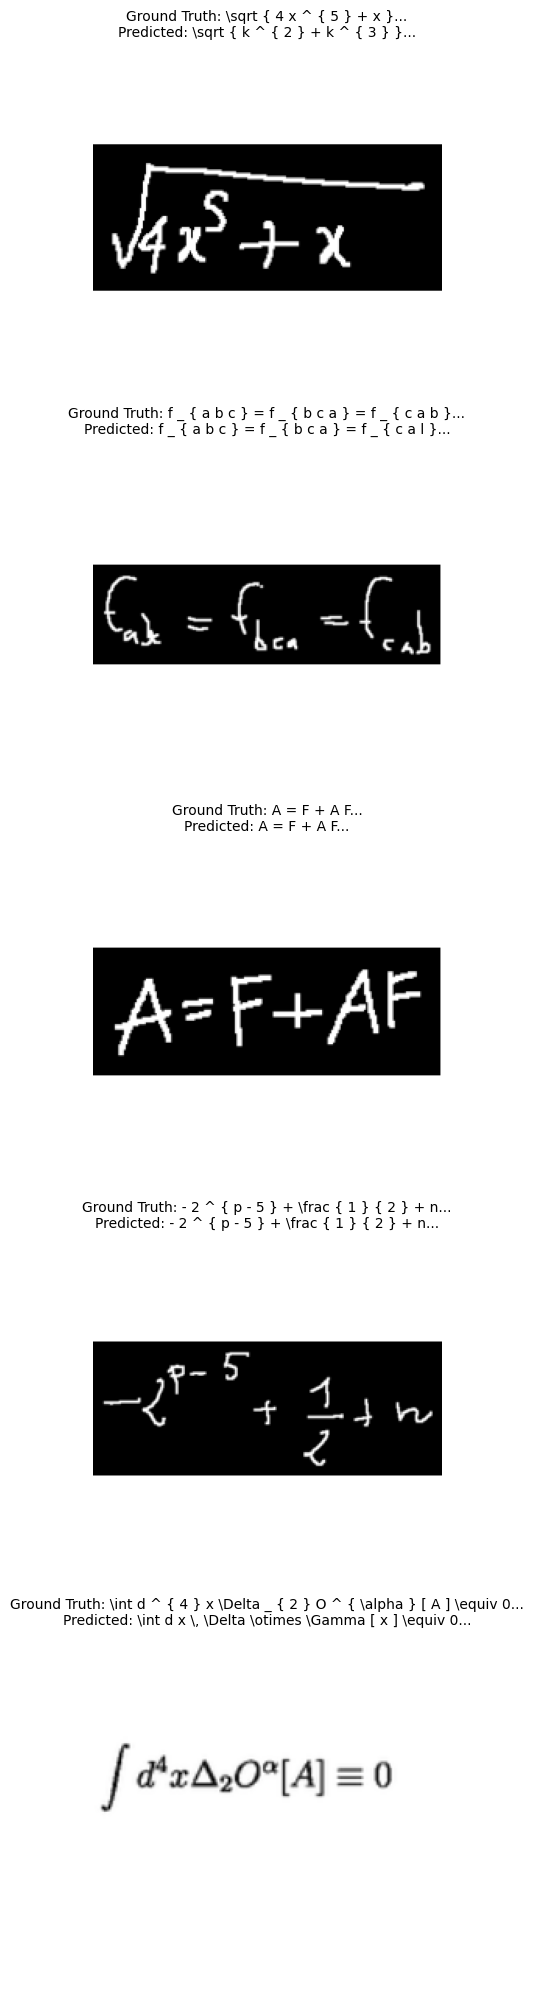

In [24]:
test_inference()